Imports!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import string
import seaborn as sns
import pickle

Connect to and read from imdb database (SQL)

In [2]:
conn = sqlite3.connect('im.db')
imdb_basics_df = pd.read_sql("""
SELECT * FROM movie_basics
;""",conn)

In [3]:
imdb_reviews_df = pd.read_sql("""
SELECT * FROM movie_ratings
;""",conn)
imdb_reviews_df
imdb_basics_df = pd.merge(how='inner',left = imdb_basics_df,right = imdb_reviews_df,left_on = imdb_basics_df.movie_id,right_on=imdb_reviews_df.movie_id)
imdb_basics_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes
0,tt0063540,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


Read The Movie Database CSV file

In [4]:
tmdb_df = pd.read_csv('tmdb.movies.csv')

Read The-Numbers.com movie budgets CSV file and call it the budget dataframe

In [5]:
budg_df = pd.read_csv('tn.movie_budgets.csv')

Read the Rotten Tomatoes databases and name them "info" and "review" respectively

In [6]:
info_df = pd.read_csv('rt.movie_info.tsv',delimiter='\t')

In [7]:
review_df = pd.read_csv('rt.reviews.tsv',delimiter='\t',encoding='windows-1252')

Create a list of unique genres which we will use to make dummy variables

In [8]:
genres = []
genre_list = list(imdb_basics_df.genres.value_counts().keys())
for x in genre_list:
    row_genres = []
    for y in x.split(','):
        genres.append(y)
genres = list(set(genres))

Convert the 'genres' column into a series of lists instead of objects concatenated with a comma

In [9]:
imdb_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key_0            73856 non-null  object 
 1   movie_id_x       73856 non-null  object 
 2   primary_title    73856 non-null  object 
 3   original_title   73856 non-null  object 
 4   start_year       73856 non-null  int64  
 5   runtime_minutes  66236 non-null  float64
 6   genres           73052 non-null  object 
 7   movie_id_y       73856 non-null  object 
 8   averagerating    73856 non-null  float64
 9   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 6.2+ MB


In [10]:
genres

['Adventure',
 'Animation',
 'Crime',
 'Documentary',
 'Musical',
 'Sport',
 'Adult',
 'Sci-Fi',
 'Romance',
 'Comedy',
 'Biography',
 'Music',
 'Horror',
 'War',
 'Thriller',
 'Family',
 'Mystery',
 'Fantasy',
 'Reality-TV',
 'Action',
 'Short',
 'Game-Show',
 'Drama',
 'News',
 'Western',
 'History']

In [11]:
imdb_basics_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes
0,tt0063540,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


In [12]:
for i,x in enumerate(imdb_basics_df.genres):
    genres_ = []
    if x is not None:
        for y in x.split(","):
            genres_.append(y)
        imdb_basics_df['genres'][i] = genres_

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\3072975444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_basics_df['genres'][i] = genres_


In [13]:

for genre in genres:        #genre is one of the unique genres from the list
    imdb_basics_df[genre] = 0
    for ind, value in enumerate(imdb_basics_df['genres']): # index is the index of the row - row is 
        if (value is not None):
            if (genre in value):
                imdb_basics_df[genre][ind]=1

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\999628234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_basics_df[genre][ind]=1
C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\999628234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_basics_df[genre][ind]=1
C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\999628234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_basics_df[genre][ind]=1
C:\Users\kapta\A

In [14]:
imdb_basics_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes,...,Mystery,Fantasy,Reality-TV,Action,Short,Game-Show,Drama,News,Western,History
0,tt0063540,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",tt0063540,7.0,77,...,0,0,0,1,0,0,1,0,0,0
1,tt0066787,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",tt0066787,7.2,43,...,0,0,0,0,0,0,1,0,0,0
2,tt0069049,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],tt0069049,6.9,4517,...,0,0,0,0,0,0,1,0,0,0
3,tt0069204,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]",tt0069204,6.1,13,...,0,0,0,0,0,0,1,0,0,0
4,tt0100275,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]",tt0100275,6.5,119,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,[Documentary],tt9913084,6.2,6,...,0,0,0,0,0,0,0,0,0,0
73852,tt9914286,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"[Drama, Family]",tt9914286,8.7,136,...,0,0,0,0,0,0,1,0,0,0
73853,tt9914642,tt9914642,Albatross,Albatross,2017,NaN,[Documentary],tt9914642,8.5,8,...,0,0,0,0,0,0,0,0,0,0
73854,tt9914942,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5,...,0,0,0,0,0,0,0,0,0,0


In [20]:
imdb_basics_df['sum_rating'] = imdb_basics_df['averagerating'] * imdb_basics_df['numvotes']

In [21]:
imdb_basics_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes,...,Fantasy,Reality-TV,Action,Short,Game-Show,Drama,News,Western,History,sum_rating
0,tt0063540,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",tt0063540,7.0,77,...,0,0,1,0,0,1,0,0,0,539.0
1,tt0066787,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",tt0066787,7.2,43,...,0,0,0,0,0,1,0,0,0,309.6
2,tt0069049,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],tt0069049,6.9,4517,...,0,0,0,0,0,1,0,0,0,31167.3
3,tt0069204,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]",tt0069204,6.1,13,...,0,0,0,0,0,1,0,0,0,79.3
4,tt0100275,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]",tt0100275,6.5,119,...,1,0,0,0,0,1,0,0,0,773.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,[Documentary],tt9913084,6.2,6,...,0,0,0,0,0,0,0,0,0,37.2
73852,tt9914286,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"[Drama, Family]",tt9914286,8.7,136,...,0,0,0,0,0,1,0,0,0,1183.2
73853,tt9914642,tt9914642,Albatross,Albatross,2017,NaN,[Documentary],tt9914642,8.5,8,...,0,0,0,0,0,0,0,0,0,68.0
73854,tt9914942,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5,...,0,0,0,0,0,0,0,0,0,33.0


We remove the punctuation and whitespace from the titles to create better matching

First make a list of all characters we want to remove

In [22]:
punct_list = list(string.punctuation) + [" "]
len(punct_list)

33

We do the replace and also set all titles to lowercase
We do this for the original title and the primary title, as well as for the titles in the budget dataframe

In [23]:
og_list = imdb_basics_df.original_title.str.lower()
for char in punct_list:
    og_list = og_list.str.replace(char,"")
og_list
imdb_basics_df['og_name'] = og_list

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\2743537487.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  og_list = og_list.str.replace(char,"")


In [24]:
prim_list = imdb_basics_df.primary_title.str.lower()
for char in punct_list:
    prim_list = prim_list.str.replace(char,"")
prim_list
imdb_basics_df['prim_name'] = prim_list

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\3155770604.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prim_list = prim_list.str.replace(char,"")


In [25]:
budget_list = budg_df.movie.str.lower()
for char in punct_list:
    budget_list = budget_list.str.replace(char,"")
budget_list
budg_df['key_name'] = budget_list
budg_df

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\3876272036.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budget_list = budget_list.str.replace(char,"")


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",piratesofthecaribbeanonstrangertides
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",darkphoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",avengersageofultron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",starwarsepviiithelastjedi
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,red11
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",following
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",returntothelandofwonders
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,aplaguesopleasant


Next we create a list of titles to act as keys to match with the budget dataframe by checking which one has a match before using it.

In [26]:
key_titles = []
target = list(budget_list)
for i,v in enumerate(list(imdb_basics_df.prim_name.values)):
    x = imdb_basics_df.og_name.values[i]
    if v in target:
        key_titles.append(v)
    elif x in target:
        key_titles.append(x)
    else: key_titles.append(np.NaN)
imdb_basics_df['key_title'] = key_titles
len(list(set(key_titles)))

2294

Pickle this data

In [27]:
imdb_basics_df.to_pickle('./imdb_basics_df.zip',compression='zip')

Before we do our join, we drop duplicates.

In [28]:

imdb_basics_df.drop_duplicates(subset = 'key_title', inplace = True)

In [29]:
budg_df.drop_duplicates(subset = 'key_name', inplace = True)

Then we can do our join

In [30]:
imdb_basics_df.drop('key_0',axis = 1,inplace=True)

In [31]:
merged_df = pd.merge(how='inner',left = imdb_basics_df,right = budg_df,left_on = imdb_basics_df.key_title,right_on=budg_df.key_name)

Loop over list of column names where floats are saved as objects and strip characters.
Then, save them as floats.

In [32]:
objects_to_floats = ['production_budget','domestic_gross','worldwide_gross']

for x in objects_to_floats:
    merged_df[x] = merged_df[x].str.replace('$',"")
    merged_df[x] = merged_df[x].str.replace(',',"")
    merged_df[x] = merged_df[x].astype('float64')

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\1951103906.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df[x] = merged_df[x].str.replace('$',"")


Create a new column that calculates profitability of a film

In [33]:
merged_df['Profitability'] = merged_df.worldwide_gross - merged_df.production_budget

Text(0, 0.5, 'Profitability of Film')

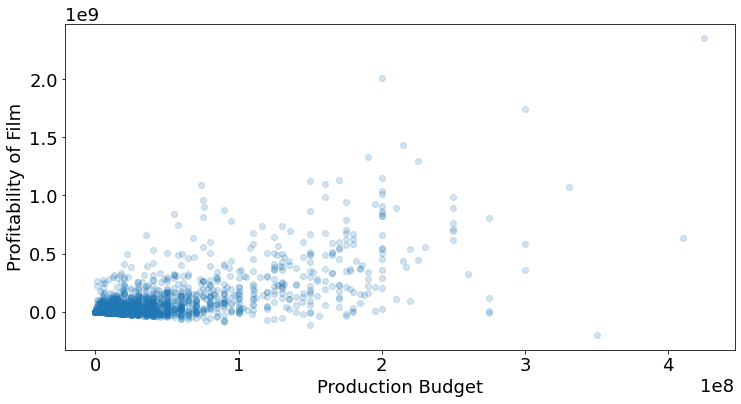

In [50]:
x=merged_df.production_budget
y=merged_df.Profitability
fig,ax = plt.subplots(figsize = (12,6))
ax.scatter(x,y,alpha=.2)
ax.set_xlabel('Production Budget')
ax.set_ylabel('Profitability of Film')
#ax.set_title('Profitability vs Production Budget');

In [35]:
merged_df['ROI_ratio'] = merged_df.Profitability / merged_df.production_budget

In [36]:
dfb = pd.DataFrame(merged_df.production_budget)
for i,x in enumerate(genres):
    dfb[x] = merged_df[x] * merged_df.production_budget
dfb

,production_budget,Adventure,Animation,Crime,Documentary,Musical,Sport,Adult,Sci-Fi,Romance,...,Mystery,Fantasy,Reality-TV,Action,Short,Game-Show,Drama,News,Western,History
0,45000000.0,0.0,45000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45000000.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25000000.0,25000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25000000.0,0.0,0.0,0.0
3,91000000.0,91000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,91000000.0,0.0,0.0,0.0
4,28000000.0,0.0,0.0,28000000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28000000.0,0.0,0.0,28000000.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,9200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9200000.0,0.0,0.0,0.0
2289,400000.0,0.0,0.0,0.0,400000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,38000000.0,0.0,0.0,0.0,38000000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,6000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,0.0,0.0,0.0


In [37]:
dfp = pd.DataFrame(merged_df.Profitability)
for i,x in enumerate(genres):
    dfp[x] = merged_df[x] * merged_df.Profitability
dfp

,Profitability,Adventure,Animation,Crime,Documentary,Musical,Sport,Adult,Sci-Fi,Romance,...,Mystery,Fantasy,Reality-TV,Action,Short,Game-Show,Drama,News,Western,History
0,-44926294.0,-0.0,-44926294.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-44926294.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,965996.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-15686698.0,-15686698.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-15686698.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-15686698.0,-0.0,-0.0,-0.0
3,96861183.0,96861183.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,96861183.0,0.0,0.0,0.0
4,34108587.0,0.0,0.0,34108587.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34108587.0,0.0,0.0,34108587.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,-5000666.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-5000666.0,-0.0,-0.0,-0.0
2289,255538.0,0.0,0.0,0.0,255538.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,11678401.0,0.0,0.0,0.0,11678401.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,12107621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12107621.0,0.0,0.0,0.0


In [38]:
col_names = list(dfp.columns)[1:]

C:\Users\kapta\AppData\Local\Temp\ipykernel_27372\2110147724.py:4: RuntimeWarning: invalid value encountered in true_divide
  vals = pd.Series(profits.values / costs.values)


Text(0, 0.5, 'ROI (Profit per Dollar Spend)')

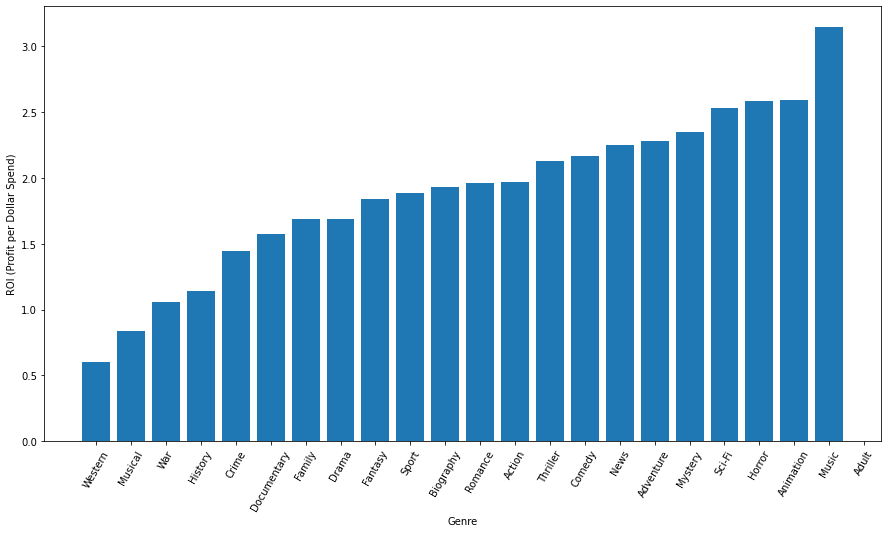

In [39]:
profits = dfp.sum(axis=0)[1:]
costs = dfb.sum(axis=0)[1:]

vals = pd.Series(profits.values / costs.values)

df_chart = pd.DataFrame(genres,columns=['genres'])
df_chart['average_ROI'] = vals
df_chart = df_chart.sort_values(by = 'average_ROI')
x =  df_chart.genres
y = df_chart.average_ROI
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 60)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (Profit per Dollar Spend)')
#ax.set_title('Average ROI by Genre')

In [40]:
profits

Adventure      9.126363e+10
Animation      2.853509e+10
Crime          1.295439e+10
Documentary    3.272835e+09
Musical        3.447241e+08
Sport          2.098256e+09
Adult          0.000000e+00
Sci-Fi         3.433108e+10
Romance        1.167470e+10
Comedy         5.260917e+10
Biography      8.296543e+09
Music          3.315941e+09
Horror         1.234549e+10
War            7.730914e+08
Thriller       2.275065e+10
Family         1.145082e+10
Mystery        9.494488e+09
Fantasy        2.210575e+10
Reality-TV     0.000000e+00
Action         7.629575e+10
Short          0.000000e+00
Game-Show      0.000000e+00
Drama          4.534860e+10
News           7.202395e+07
Western        4.770456e+08
History        1.990735e+09
dtype: float64

Text(0, 0.5, 'Profitability (Total Profit for Film)')

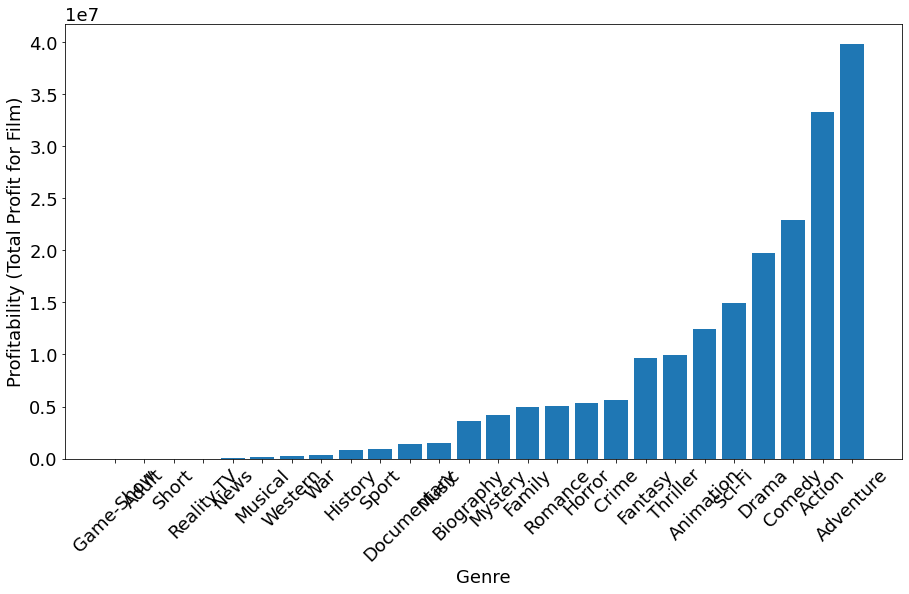

In [41]:
vals = dfp.mean(axis=0)[1:].sort_values()
plt.rcParams.update({'font.size': 18})
x = vals.keys()
y = vals.values
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Profitability (Total Profit for Film)')
#ax.set_title('Average Profitability by Genre')

In [42]:
merged_df['number_of_genres'] = merged_df.genres.str.len()
merged_df

,key_0,movie_id_x,primary_title,original_title,start_year,runtime_minutes,genres,movie_id_y,averagerating,numvotes,...,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,key_name,Profitability,ROI_ratio,number_of_genres
0,foodfight,tt0249516,Foodfight!,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",tt0249516,1.9,8248,...,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,foodfight,-44926294.0,-0.998362,3.0
1,theovernight,tt0326592,The Overnight,The Overnight,2010,88.0,None,tt0326592,7.5,24,...,21,"Jun 19, 2015",The Overnight,200000.0,1109808.0,1165996.0,theovernight,965996.0,4.829980,NaN
2,ontheroad,tt0337692,On the Road,On the Road,2012,124.0,"[Adventure, Drama, Romance]",tt0337692,6.1,37886,...,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,ontheroad,-15686698.0,-0.627468,3.0
3,thesecretlifeofwaltermitty,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"[Adventure, Comedy, Drama]",tt0359950,7.3,275300,...,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,thesecretlifeofwaltermitty,96861183.0,1.064409,3.0
4,awalkamongthetombstones,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"[Action, Crime, Drama]",tt0365907,6.5,105116,...,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,awalkamongthetombstones,34108587.0,1.218164,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,richardiii,tt8680254,Richard III,Richard III,2016,NaN,[Drama],tt8680254,9.1,28,...,65,"Dec 29, 1995",Richard III,9200000.0,2684904.0,4199334.0,richardiii,-5000666.0,-0.543551,1.0
2289,heroes,tt8824064,Heroes,Heroes,2019,88.0,[Documentary],tt8824064,7.3,7,...,12,"Oct 24, 2008",Heroes,400000.0,655538.0,655538.0,heroes,255538.0,0.638845,1.0
2290,push,tt8976772,Push,Push,2019,92.0,[Documentary],tt8976772,7.3,33,...,70,"Feb 6, 2009",Push,38000000.0,31811527.0,49678401.0,push,11678401.0,0.307326,1.0
2291,unplanned,tt9024106,Unplanned,Unplanned,2019,106.0,"[Biography, Drama]",tt9024106,6.3,5945,...,33,"Mar 29, 2019",Unplanned,6000000.0,18107621.0,18107621.0,unplanned,12107621.0,2.017937,2.0


Text(0, 0.5, 'Average Profitability for Films)')

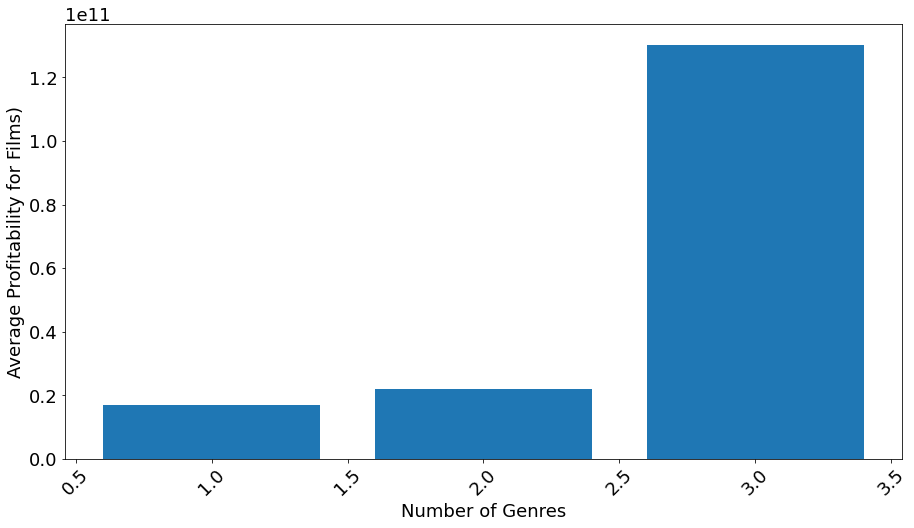

In [43]:
chart_data = merged_df.groupby('number_of_genres').sum()

x = chart_data.index
y = chart_data['Profitability']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Average Profitability for Films)')
#ax.set_title('Average Profitability by Number of Genres')

Text(0, 0.5, 'Profitability (Average ROI for Films)')

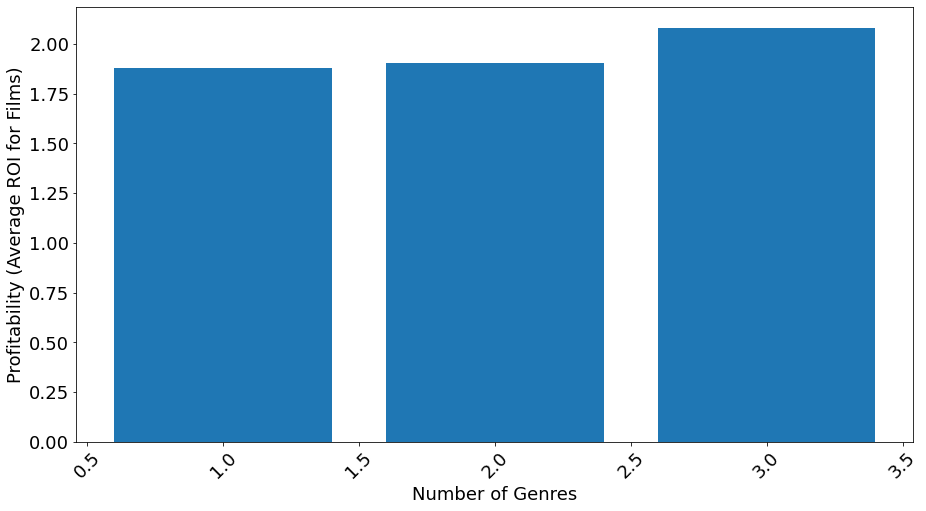

In [44]:
x = chart_data.index
y = chart_data['Profitability']/chart_data['production_budget']
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Number of Genres')
ax.set_ylabel('Profitability (Average ROI for Films)')
#ax.set_title('Average ROI by Number of Genres')

In [45]:
chart_data.index

Float64Index([1.0, 2.0, 3.0], dtype='float64', name='number_of_genres')

In [46]:
dfn = pd.DataFrame(imdb_basics_df.numvotes)
for i,x in enumerate(genres):
    dfn[x] = imdb_basics_df[x] * imdb_basics_df.numvotes

Text(0, 0.5, 'Average Number of Ratings for Films)')

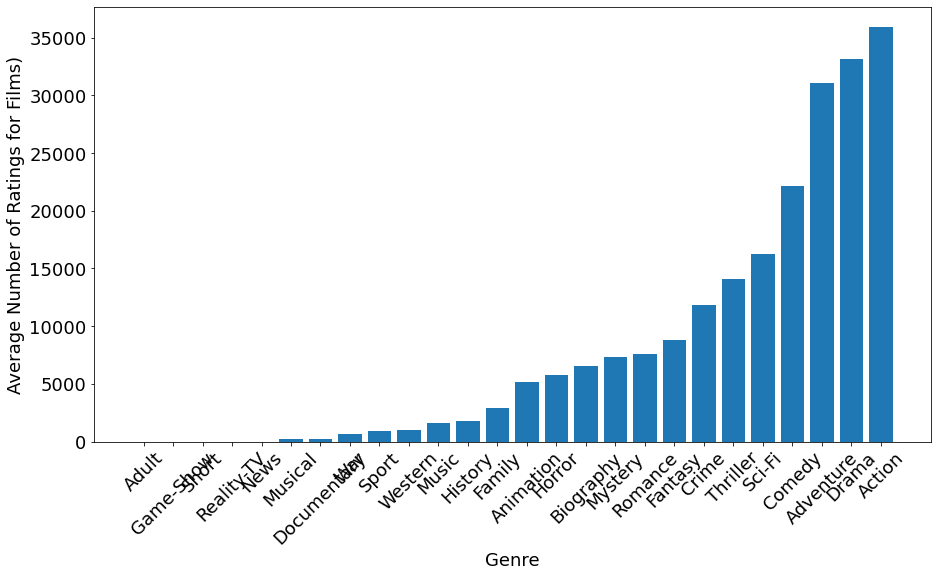

In [47]:
vals = dfn.mean(axis=0)[1:].sort_values()
x = vals.keys()
y = vals.values
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 45)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Number of Ratings for Films)')
#ax.set_title('Average Number of Ratings by Genre')

In [48]:
dfr = pd.DataFrame(imdb_basics_df.sum_rating)
for i,x in enumerate(genres):
    dfr[x] = imdb_basics_df[x] * imdb_basics_df.sum_rating

Text(0, 0.5, 'Number of Ratings per Dollar Spend')

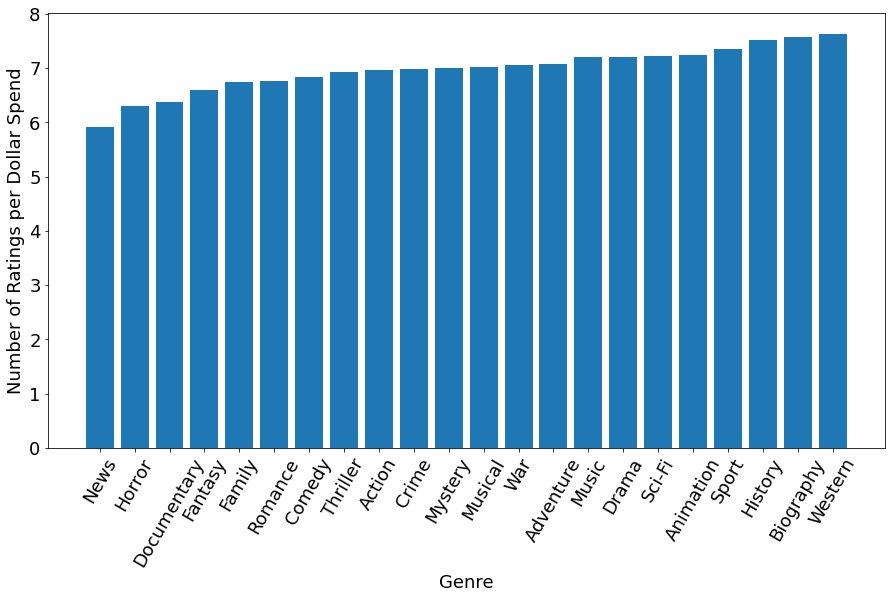

In [49]:
df_chart = pd.DataFrame(dfn.sum(axis=0)[1:],columns=['num_ratings'])
df_chart['sum_ratings'] = dfr.sum(axis=0)[1:].values
df_chart['average_rating'] = df_chart.sum_ratings / df_chart.num_ratings
df_chart = df_chart.sort_values(by='average_rating')
df_chart.dropna(inplace=True)
df_chart
x = df_chart.index
y = df_chart.average_rating
fig,ax=plt.subplots(figsize=(15,8))
plt.xticks(rotation = 60)
ax.bar(x,y)
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Ratings per Dollar Spend')
#ax.set_title('Average ROI by Genre')